In [1]:
from __future__ import print_function, division

# from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
# from tensorflow_addons.layers import InstanceNormalization
from tensorflow.keras.layers import BatchNormalization as InstanceNormalization

from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate, BatchNormalization, Activation, ZeroPadding2D
# from keras.layers.advanced_activations import LeakyReLU
from keras.layers import LeakyReLU

# from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.layers import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img

from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import numpy as np
import datetime
import natsort
import scipy
import sys
import os
import cv2
import tensorflow as tf
tf.config.run_functions_eagerly(True)


## Helper Function

In [2]:
def load_filename(path):
    dirFiles = os.listdir(path)
    for i, file in enumerate(dirFiles):
        dirFiles[i] = path + file
    return natsort.natsorted(dirFiles ,reverse=False)

# load all images in a directory into memory
def load_images(list_path, size=(256, 256)):
    img_list = list()
    # enumerate filenames in directory, assume all are images
    for filename in list_path:
        # load and resize the image
        pixels = load_img(filename, target_size=size)
        # convert to numpy array
        pixels = img_to_array(pixels)
        pixels = (pixels - 127.5) / 127.5
        img_list.append(pixels)
    return np.asarray(img_list)

In [3]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
    # unpack dataset
    trainA, trainB = dataset

    # choose random instances
    ix = np.random.randint(0, trainA.shape[0], n_samples)
    
    # retrieve selected images
    X1, X2 = trainA[ix], trainB[ix]
    
    # generate 'real' class labels (1)
    y = np.ones((n_samples, patch_shape, patch_shape, 1))
    
    return [X1, X2], y

# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
    # generate fake instance
    X = g_model.predict(samples)
    
    # create 'fake' class labels (0)
    y = np.zeros((len(X), patch_shape, patch_shape, 1))
    
    return X, y

In [4]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, d_model, dataset, target_dir='', n_samples=3):
    if target_dir and not os.path.exists(target_dir):
        os.mkdir(target_dir)
    # select a sample of input images
    [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
    # generate a batch of fake samples
    X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
    # scale all pixels from [-1,1] to [0,1]
    X_realA = (X_realA + 1) / 2.0
    X_realB = (X_realB + 1) / 2.0
    X_fakeB = (X_fakeB + 1) / 2.0
    # plot real source images
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + i)
        plt.axis('off')
        plt.imshow(X_realA[i])
    # plot generated target image
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples + i)
        plt.axis('off')
        plt.imshow(X_fakeB[i])
    # plot real target image
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples*2 + i)
        plt.axis('off')
        plt.imshow(X_realB[i])
    # save plot to file
    filename1 = 'plot_%06d.png' % (step+1)
    plt.savefig(target_dir + filename1)
    plt.close()
    # save the generator model
    g_model.save(target_dir + 'g_model.h5')
    
    # save the discriminator model
    d_model.save(target_dir + 'd_model.h5')
    
    print('>Saved: %s and %s' % (filename1, 'g_model & d_model'))

## Generator

In [5]:
def generator(img_shape):
    def conv2d(layer_in, n_filter, norm=True):
        d = Conv2D(n_filter, kernel_size=4, strides=2, padding='same')(layer_in)
        d = LeakyReLU(0.2)(d)
        if norm:
            d = InstanceNormalization()(d)
        return d
    
    def deconv2d(layer_in, skip_in, n_filter, dropout=0.5):
        d = UpSampling2D(size=2)(layer_in)
        d = Conv2D(n_filter, kernel_size=4, strides=1, padding='same', activation='relu')(d)
        if dropout:
            d = Dropout(dropout)(d)
        d = InstanceNormalization()(d)
        d = Concatenate()([d, skip_in])
        return d
    
    # Input Layer
    in_img = Input(shape=img_shape)
    
    # Downsampling
    d1 = conv2d(in_img, 64, norm=False)
    d2 = conv2d(d1, 128)
    d3 = conv2d(d2, 256)
    d4 = conv2d(d3, 512)
    d5 = conv2d(d4, 512)
    d6 = conv2d(d5, 512)
    d7 = conv2d(d6, 512)
    
    # Upsampling
    u1 = deconv2d(d7, d6, 512)
    u2 = deconv2d(u1, d5, 512)
    u3 = deconv2d(u2, d4, 512)
    u4 = deconv2d(u3, d3, 256, dropout=0)
    u5 = deconv2d(u4, d2, 128, dropout=0)
    u6 = deconv2d(u5, d1, 64, dropout=0)
    u7 = UpSampling2D(size=2)(u6)
    
    out_img = Conv2D(3, kernel_size=4, strides=1, padding='same', activation='tanh')(u7)
    
    return Model(in_img, out_img, name='generator')

## Discriminator

In [6]:
def discriminator(img_shape):
    def d_layer(layer_in, n_filter, norm=True):
        d = Conv2D(n_filter, kernel_size=4, strides=2, padding='same')(layer_in)
        d = LeakyReLU(0.2)(d)
        if norm:
            d = InstanceNormalization()(d)
        return d
    
    in_src_img = Input(shape=img_shape)
    in_target_img = Input(shape=img_shape)
    
    merged = Concatenate()([in_src_img, in_target_img])
    
    d1 = d_layer(merged, 64, norm=False)
    d2 = d_layer(d1, 128)
    d3 = d_layer(d1, 256)
    d4 = d_layer(d1, 512)

    out = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)
    
    return Model([in_src_img, in_target_img], out, name='discriminator')

## GAN

In [7]:
def GAN(g_model, d_model, img_shape):
    d_model.trainable = False
    in_img = Input(shape=img_shape)
    gen_out = g_model(in_img)
    dis_out = d_model([in_img, gen_out])
    model = Model(in_img, [dis_out, gen_out], name='GAN')
    return model

## Train GAN model

In [8]:
def train(d_model, g_model, gan_model, data, target_dir, n_epochs=150, n_batch=32):
    # determine the output square shape of the discriminator
    n_patch = d_model.output_shape[1]
    
    blue_photo = data[0]
    blue_sketch = data[1]
    
    for i in range(n_epochs):
        print(' ========== Epoch', i+1, '========== ')
        
        blue_photo, blue_sketch = shuffle(blue_photo, blue_sketch)

        for j in range(int(len(blue_photo)/n_batch)):
            
            start = int(j*n_batch)
            end = int(min(len(blue_photo), (j*n_batch)+n_batch))
            
            dataset = [load_images(blue_photo[start:end]), load_images(blue_sketch[start:end])]

            # select a batch of real samples
            [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
            
            # generate a batch of fake samples
            X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
            
            # update discriminator for real samples
            d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
            
            # update discriminator for generated samples
            d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
            
            d_loss = 0.5 * np.add(d_loss1, d_loss2)
            
            # update the generator
            g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
            
            # summarize performance
            print('Batch : %d, D Loss : %.3f | G Loss : %.3f' % (j+1, d_loss, g_loss))
        
        # summarize model performance
#         if (i+1) % 10 == 0:
        summarize_performance(i, g_model, d_model, dataset, target_dir)

## Loss Function

In [9]:
import tensorflow as tf
import keras.backend as K
from keras.losses import mean_absolute_error
import tensorflow.keras.backend as K  

def pixel_loss(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred))

def contextual_loss (y_true, y_pred):
    a = tf.image.rgb_to_grayscale(tf.slice(
                                y_pred, 
                                [0,0,0,0], 
                                [16, 256, 256, 3]))
    
    b = tf.image.rgb_to_grayscale(tf.slice(
                                y_true, 
                                [0,0,0,0], 
                                [16, 256, 256, 3]))
    
    y_pred = tf.divide(tf.add(tf.reshape(a, [tf.shape(a)[0], -1]), 1), 2)
    y_true = tf.divide(tf.add(tf.reshape(b, [tf.shape(b)[0], -1]), 1), 2)
    
#     tf.assert_rank(y_true,2)
#     tf.assert_rank(y_pred,2)
    
    p_shape = tf.shape(y_true)
    q_shape = tf.shape(y_pred)
#     tf.assert_equal(p_shape, q_shape)
    
    # normalize sum to 1
    p_ = tf.divide(y_true, tf.tile(tf.expand_dims(tf.reduce_sum(y_true, axis=1), 1), [1,p_shape[1]]))
    q_ = tf.divide(y_pred, tf.tile(tf.expand_dims(tf.reduce_sum(y_pred, axis=1), 1), [1,p_shape[1]]))
    
    return tf.reduce_sum(tf.multiply(p_, tf.math.log(tf.divide(p_, q_))), axis=1)

def total_loss (y_true, y_pred):

    px_loss = pixel_loss(y_true, y_pred)

    ctx_loss = contextual_loss(y_true, y_pred)
    
    return (0.2 * px_loss) + (0.8 * ctx_loss)

## Load Dataset

In [10]:
# dataset path
b_photo_path = 'Dataset/Augmented photo/'
b_sketch_path = 'Dataset/Augmented sketch/'

blue_photo = load_filename(b_photo_path)
blue_sketch = load_filename(b_sketch_path)

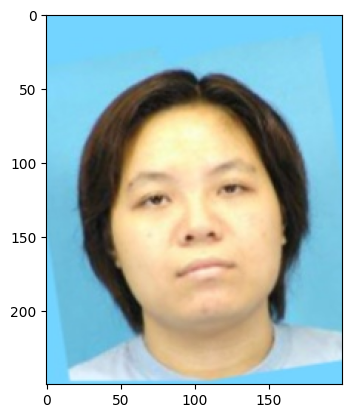

In [11]:
plt.imshow(cv2.cvtColor(cv2.imread(blue_photo[1500]).astype('uint8'), cv2.COLOR_BGR2RGB))

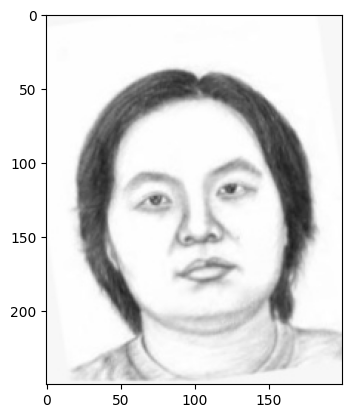

In [12]:
plt.imshow(cv2.cvtColor(cv2.imread(blue_sketch[1500]).astype('uint8'), cv2.COLOR_BGR2RGB))

## Define GAN Model

In [13]:
img_shape = (256, 256, 3)

d_model = discriminator(img_shape)

g_model = generator(img_shape)

gan_model = GAN(g_model, d_model, img_shape)

In [14]:
gan_model.summary()

Model: "GAN"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ generator           │ (None, 256, 256,  │ 41,843,331 │ input_layer_3[0]… │
│ (Functional)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ discriminator       │ (None, 64, 64, 1) │    541,249 │ input_layer_3[0]… │
│ (Functional)        │                   │            │ generator[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 42,384,580 (161.68 MB)

 Trainable params: 41,834,499 (159.59 MB)

 Non-trainable params: 550,081 (2.10 MB)

In [15]:
from keras.optimizers import Adam  # Ensure Adam is imported properly
d_model.trainable = True
g_model.trainable = True
gan_model.trainable = True

opt = Adam(learning_rate=2e-4, beta_1=0.5)


d_model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
gan_model.compile(loss=['binary_crossentropy', total_loss], optimizer=opt, loss_weights=[1,100])

In [16]:
# # Ensure models are trainable before compiling
# d_model.trainable = True
# g_model.trainable = True
# gan_model.trainable = True

# # Compile models again after setting them as trainable
# d_model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
# gan_model.compile(loss=['binary_crossentropy', total_loss], optimizer=opt, loss_weights=[1,100])


## Start Training

In [18]:
# import os
# import numpy as np
# from keras.layers import Input
# from keras.models import Model
# from keras.optimizers import Adam
# import tensorflow.keras.backend as K

# Your GAN function:
def GAN(g_model, d_model, img_shape):
    d_model.trainable = False
    in_img = Input(shape=img_shape)
    gen_out = g_model(in_img)
    dis_out = d_model([in_img, gen_out])
    model = Model(in_img, [dis_out, gen_out], name='GAN')
    return model

# --- Assume you have already built your g_model and d_model, and loaded weights into them ---
# For example:
# d_model.load_weights('Models/Pixel[02]_Context[08]/discriminator_.weight.h5')
# g_model.load_weights('Models/Pixel[02]_Context[08]/g_model.h5')

# Set the image shape (adjust if needed)
img_shape = (256, 256, 3)

# Rebuild the GAN model using your function:
gan_model = GAN(g_model, d_model, img_shape)

# Compile the GAN model. Use run_eagerly=True to help debug any loss output issues.
opt = Adam(learning_rate=0.0002, beta_1=0.5)

gan_model.compile(optimizer=opt, 
                  loss=['binary_crossentropy', pixel_loss],  # using your pixel_loss as second loss
                  loss_weights=[1, 100],
                  run_eagerly=True)

# Now, resume training with your custom train() function:
# Make sure blue_sketch and blue_photo are loaded properly (as numpy arrays or lists convertible to arrays)
train(
    d_model, 
    g_model, 
    gan_model, 
    [blue_sketch[:1500], blue_photo[:1500]],  # Note: your train() function expects [blue_photo, blue_sketch] ordering; adjust if necessary.
    'Models/Pixel[02]_Context[08]/', 
    n_epochs=150, 
    n_batch=32 # Resume training from epoch 28 (since 27 epochs are complete)
)


 ========== Epoch 1 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


c:\Users\rahul\sath\Lib\site-packages\keras\src\backend\tensorflow\trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Batch : 1, D Loss : 3.796 | G Loss : 100.816
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batch : 2, D Loss : 3.705 | G Loss : 86.010
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batch : 3, D Loss : 3.661 | G Loss : 76.020
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batch : 4, D Loss : 3.636 | G Loss : 69.829
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batch : 5, D Loss : 3.618 | G Loss : 65.552
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batch : 6, D Loss : 3.612 | G Loss : 62.636
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batch : 7, D Loss : 3.614 | G Loss : 60.279
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batch : 8, D Loss : 3.616 | G Loss : 58.312
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batch : 9, D Loss : 3.606 | G Loss : 56.519
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batch : 10, D Loss : 3.597 | G Loss : 54.791
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batch : 11, D Loss : 3.599 | G Loss : 53.306
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batch : 12, D Loss : 3.593 | G Loss : 51.910
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batch : 13, D Loss : 3.595 | G Loss 

>Saved: plot_000001.png and g_model & d_model
 ========== Epoch 2 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.567 | G Loss : 36.602
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.565 | G Loss : 36.423
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.564 | G Loss : 36.272
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.564 | G Loss : 36.165
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.564 | G Loss : 36.090
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.564 | G Loss : 36.013
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.566 | G Loss : 35.920
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.567 | G Loss : 35.811
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.567 | G Loss : 35.698
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.569 | G Loss : 35.585
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.568 | G Loss : 35.503
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batc

>Saved: plot_000002.png and g_model & d_model
 ========== Epoch 3 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batch : 1, D Loss : 3.558 | G Loss : 32.044
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.557 | G Loss : 31.974
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.558 | G Loss : 31.939
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.559 | G Loss : 31.869
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.559 | G Loss : 31.801
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.559 | G Loss : 31.744
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.559 | G Loss : 31.686
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.560 | G Loss : 31.645
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.560 | G Loss : 31.600
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.559 | G Loss : 31.543
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.559 | G Loss : 31.491
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batc

>Saved: plot_000003.png and g_model & d_model
 ========== Epoch 4 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batch : 1, D Loss : 3.557 | G Loss : 30.178
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batch : 2, D Loss : 3.556 | G Loss : 30.150
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batch : 3, D Loss : 3.556 | G Loss : 30.105
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.556 | G Loss : 30.064
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.556 | G Loss : 30.025
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.556 | G Loss : 29.986
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.556 | G Loss : 29.986
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batch : 8, D Loss : 3.556 | G Loss : 29.970
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batch : 9, D Loss : 3.555 | G Loss : 29.953
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.556 | G Loss : 29.933
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.556 | G Loss : 29.905
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batc

>Saved: plot_000004.png and g_model & d_model
 ========== Epoch 5 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batch : 1, D Loss : 3.555 | G Loss : 28.886
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batch : 2, D Loss : 3.554 | G Loss : 28.872
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batch : 3, D Loss : 3.554 | G Loss : 28.849
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batch : 4, D Loss : 3.554 | G Loss : 28.830
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.554 | G Loss : 28.810
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.554 | G Loss : 28.785
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batch : 7, D Loss : 3.554 | G Loss : 28.761
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.553 | G Loss : 28.736
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.554 | G Loss : 28.712
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batch : 10, D Loss : 3.554 | G Loss : 28.684
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batch : 11, D Loss : 3.554 | G Loss : 28.656
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batc

>Saved: plot_000005.png and g_model & d_model
 ========== Epoch 6 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batch : 1, D Loss : 3.555 | G Loss : 27.903
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 27.884
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 27.865
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batch : 4, D Loss : 3.556 | G Loss : 27.848
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.556 | G Loss : 27.826
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.556 | G Loss : 27.802
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.556 | G Loss : 27.781
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.556 | G Loss : 27.758
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 27.737
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 27.717
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 27.696
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batc

>Saved: plot_000006.png and g_model & d_model
 ========== Epoch 7 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batch : 1, D Loss : 3.555 | G Loss : 27.144
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 27.127
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 27.108
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 27.094
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batch : 5, D Loss : 3.555 | G Loss : 27.078
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 27.063
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 27.048
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.554 | G Loss : 27.031
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.554 | G Loss : 27.016
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 27.002
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 26.987
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batc

>Saved: plot_000007.png and g_model & d_model
 ========== Epoch 8 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.554 | G Loss : 26.519
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batch : 2, D Loss : 3.554 | G Loss : 26.510
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batch : 3, D Loss : 3.554 | G Loss : 26.502
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.554 | G Loss : 26.494
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.554 | G Loss : 26.484
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.554 | G Loss : 26.474
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.554 | G Loss : 26.463
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.554 | G Loss : 26.450
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.554 | G Loss : 26.438
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.554 | G Loss : 26.424
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.553 | G Loss : 26.409
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batc

>Saved: plot_000008.png and g_model & d_model
 ========== Epoch 9 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.553 | G Loss : 26.064
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.553 | G Loss : 26.054
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batch : 3, D Loss : 3.553 | G Loss : 26.044
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.553 | G Loss : 26.032
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.553 | G Loss : 26.019
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.553 | G Loss : 26.008
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.553 | G Loss : 25.999
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.553 | G Loss : 25.990
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batch : 9, D Loss : 3.553 | G Loss : 25.981
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batch : 10, D Loss : 3.553 | G Loss : 25.970
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batch : 11, D Loss : 3.553 | G Loss : 25.961
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batc

>Saved: plot_000009.png and g_model & d_model
 ========== Epoch 10 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batch : 1, D Loss : 3.554 | G Loss : 25.664
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batch : 2, D Loss : 3.554 | G Loss : 25.655
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batch : 3, D Loss : 3.554 | G Loss : 25.646
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.554 | G Loss : 25.636
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.554 | G Loss : 25.626
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.554 | G Loss : 25.620
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.554 | G Loss : 25.615
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.553 | G Loss : 25.605
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.554 | G Loss : 25.599
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.554 | G Loss : 25.591
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.553 | G Loss : 25.581
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Bat

>Saved: plot_000010.png and g_model & d_model
 ========== Epoch 11 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.553 | G Loss : 25.291
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.553 | G Loss : 25.287
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.553 | G Loss : 25.282
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.553 | G Loss : 25.274
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.553 | G Loss : 25.266
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.553 | G Loss : 25.259
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.553 | G Loss : 25.252
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.553 | G Loss : 25.245
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.553 | G Loss : 25.239
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batch : 10, D Loss : 3.553 | G Loss : 25.232
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.553 | G Loss : 25.226
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Bat

>Saved: plot_000011.png and g_model & d_model
 ========== Epoch 12 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.553 | G Loss : 24.985
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.553 | G Loss : 24.978
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batch : 3, D Loss : 3.553 | G Loss : 24.968
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.553 | G Loss : 24.960
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.553 | G Loss : 24.952
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.553 | G Loss : 24.944
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.553 | G Loss : 24.937
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.553 | G Loss : 24.929
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.553 | G Loss : 24.924
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.553 | G Loss : 24.918
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.553 | G Loss : 24.912
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Bat

>Saved: plot_000012.png and g_model & d_model
 ========== Epoch 13 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.553 | G Loss : 24.678
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.553 | G Loss : 24.670
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.553 | G Loss : 24.663
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.553 | G Loss : 24.656
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.553 | G Loss : 24.649
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.553 | G Loss : 24.643
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.553 | G Loss : 24.636
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.553 | G Loss : 24.629
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.553 | G Loss : 24.622
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.553 | G Loss : 24.616
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.553 | G Loss : 24.609
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Bat

>Saved: plot_000013.png and g_model & d_model
 ========== Epoch 14 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.554 | G Loss : 24.409
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.554 | G Loss : 24.402
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.554 | G Loss : 24.397
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.554 | G Loss : 24.391
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.554 | G Loss : 24.385
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.554 | G Loss : 24.381
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.554 | G Loss : 24.376
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.554 | G Loss : 24.372
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.554 | G Loss : 24.366
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.554 | G Loss : 24.365
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.554 | G Loss : 24.364
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Bat

>Saved: plot_000014.png and g_model & d_model
 ========== Epoch 15 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.554 | G Loss : 24.207
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.554 | G Loss : 24.201
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.554 | G Loss : 24.195
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.554 | G Loss : 24.190
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.554 | G Loss : 24.188
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.554 | G Loss : 24.188
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.554 | G Loss : 24.187
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.554 | G Loss : 24.184
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.554 | G Loss : 24.181
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.554 | G Loss : 24.178
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.554 | G Loss : 24.173
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Bat

>Saved: plot_000015.png and g_model & d_model
 ========== Epoch 16 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 24.026
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 24.022
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.554 | G Loss : 24.017
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 24.012
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 24.008
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 24.004
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.554 | G Loss : 23.999
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 23.994
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.554 | G Loss : 23.989
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.554 | G Loss : 23.985
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.554 | G Loss : 23.980
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Bat

>Saved: plot_000016.png and g_model & d_model
 ========== Epoch 17 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 23.818
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 23.816
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 23.813
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 23.809
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 23.804
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 23.799
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 23.795
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 23.791
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 23.786
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 23.781
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 23.776
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Bat

>Saved: plot_000017.png and g_model & d_model
 ========== Epoch 18 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 23.634
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 23.629
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 23.624
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 23.620
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 23.616
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 23.612
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 23.610
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 23.607
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 23.604
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 23.599
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 23.597
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Bat

>Saved: plot_000018.png and g_model & d_model
 ========== Epoch 19 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 23.474
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 23.473
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batch : 3, D Loss : 3.555 | G Loss : 23.472
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 23.468
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 23.466
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 23.463
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 23.458
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 23.455
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 23.452
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 23.447
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 23.444
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Bat

>Saved: plot_000019.png and g_model & d_model
 ========== Epoch 20 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 23.318
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 23.314
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 23.310
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 23.306
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 23.305
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 23.303
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 23.300
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 23.297
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 23.294
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 23.291
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 23.287
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Bat

>Saved: plot_000020.png and g_model & d_model
 ========== Epoch 21 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 23.182
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 23.179
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 23.176
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 23.172
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 23.169
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 23.165
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 23.163
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 23.160
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 23.157
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 23.154
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 23.150
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Bat

>Saved: plot_000021.png and g_model & d_model
 ========== Epoch 22 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 23.042
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 23.039
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 23.036
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 23.033
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 23.030
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 23.027
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 23.024
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 23.020
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 23.016
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 23.012
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 23.008
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Bat

>Saved: plot_000022.png and g_model & d_model
 ========== Epoch 23 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 22.901
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 22.898
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 22.895
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 22.891
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 22.889
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.554 | G Loss : 22.885
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 22.883
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 22.880
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.554 | G Loss : 22.877
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.554 | G Loss : 22.873
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batch : 11, D Loss : 3.554 | G Loss : 22.869
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Bat

>Saved: plot_000023.png and g_model & d_model
 ========== Epoch 24 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 22.827
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 22.825
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 22.823
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 22.822
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 22.820
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batch : 6, D Loss : 3.555 | G Loss : 22.818
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 22.816
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 22.814
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 22.811
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 22.808
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 22.805
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Bat

>Saved: plot_000024.png and g_model & d_model
 ========== Epoch 25 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 22.720
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 22.718
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 22.716
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 22.713
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 22.711
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 22.708
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batch : 7, D Loss : 3.555 | G Loss : 22.706
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 22.704
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 22.701
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 22.698
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 22.696
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Bat

>Saved: plot_000025.png and g_model & d_model
 ========== Epoch 26 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.554 | G Loss : 22.621
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.554 | G Loss : 22.619
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.554 | G Loss : 22.618
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.554 | G Loss : 22.615
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.554 | G Loss : 22.612
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.554 | G Loss : 22.609
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.554 | G Loss : 22.607
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.554 | G Loss : 22.605
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.554 | G Loss : 22.603
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.554 | G Loss : 22.602
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.554 | G Loss : 22.602
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Bat

>Saved: plot_000026.png and g_model & d_model
 ========== Epoch 27 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.554 | G Loss : 22.519
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 22.518
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 22.516
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 22.514
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 22.513
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 22.513
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 22.514
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 22.513
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 22.511
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 22.508
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 22.506
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Bat

>Saved: plot_000027.png and g_model & d_model
 ========== Epoch 28 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 22.427
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 22.424
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 22.421
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.554 | G Loss : 22.420
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.554 | G Loss : 22.417
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.554 | G Loss : 22.415
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.554 | G Loss : 22.413
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.554 | G Loss : 22.411
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.554 | G Loss : 22.408
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.554 | G Loss : 22.406
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.554 | G Loss : 22.403
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Bat

>Saved: plot_000028.png and g_model & d_model
 ========== Epoch 29 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.554 | G Loss : 22.328
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 22.326
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.554 | G Loss : 22.324
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.554 | G Loss : 22.321
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.554 | G Loss : 22.319
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 22.318
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 22.315
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 22.313
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 22.312
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 22.311
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 22.309
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Bat

>Saved: plot_000029.png and g_model & d_model
 ========== Epoch 30 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.554 | G Loss : 22.242
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.554 | G Loss : 22.240
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.554 | G Loss : 22.239
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.554 | G Loss : 22.237
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.554 | G Loss : 22.235
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.554 | G Loss : 22.233
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.554 | G Loss : 22.232
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.554 | G Loss : 22.232
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.554 | G Loss : 22.233
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.554 | G Loss : 22.232
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 22.231
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Bat

>Saved: plot_000030.png and g_model & d_model
 ========== Epoch 31 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 22.194
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 22.192
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 22.191
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 22.189
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 22.188
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 22.187
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 22.186
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 22.186
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 22.186
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 22.184
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 22.183
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Bat

>Saved: plot_000031.png and g_model & d_model
 ========== Epoch 32 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 22.118
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 22.117
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 22.114
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 22.113
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 22.111
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 22.109
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 22.107
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 22.105
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 22.105
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 22.103
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 22.101
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Bat

>Saved: plot_000032.png and g_model & d_model
 ========== Epoch 33 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 22.037
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 22.035
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 22.034
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 22.032
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 22.030
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 22.028
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 22.026
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 22.025
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 22.023
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 22.021
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 22.020
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Bat

>Saved: plot_000033.png and g_model & d_model
 ========== Epoch 34 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 21.965
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 21.963
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 21.962
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 21.960
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 21.959
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 21.957
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 21.957
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 21.955
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 21.953
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 21.952
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 21.950
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Bat

>Saved: plot_000034.png and g_model & d_model
 ========== Epoch 35 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 21.900
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 21.899
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 21.898
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 21.896
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 21.894
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 21.892
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 21.891
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 21.890
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 21.890
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 21.890
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 21.889
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Bat

>Saved: plot_000035.png and g_model & d_model
 ========== Epoch 36 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 21.848
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 21.846
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 21.845
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 21.844
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 21.843
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 21.842
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 21.840
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 21.839
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 21.837
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 21.835
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 21.834
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Bat

>Saved: plot_000036.png and g_model & d_model
 ========== Epoch 37 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 21.774
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 21.773
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 21.771
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 21.770
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 21.770
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batch : 6, D Loss : 3.555 | G Loss : 21.769
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 21.768
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 21.768
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 21.766
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 21.764
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 21.763
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Bat

>Saved: plot_000037.png and g_model & d_model
 ========== Epoch 38 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 21.737
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 21.735
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 21.734
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 21.733
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 21.732
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 21.731
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 21.729
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 21.727
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 21.727
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 21.726
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 21.725
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Bat

>Saved: plot_000038.png and g_model & d_model
 ========== Epoch 39 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 21.672
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 21.670
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 21.669
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 21.668
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 21.667
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 21.666
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 21.665
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 21.664
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.554 | G Loss : 21.662
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.554 | G Loss : 21.660
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 21.659
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Bat

>Saved: plot_000039.png and g_model & d_model
 ========== Epoch 40 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.554 | G Loss : 21.613
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.554 | G Loss : 21.611
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 21.609
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.554 | G Loss : 21.608
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.554 | G Loss : 21.607
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.554 | G Loss : 21.605
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.554 | G Loss : 21.603
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.554 | G Loss : 21.602
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.554 | G Loss : 21.600
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.554 | G Loss : 21.599
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.554 | G Loss : 21.598
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Bat

>Saved: plot_000040.png and g_model & d_model
 ========== Epoch 41 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.554 | G Loss : 21.549
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.554 | G Loss : 21.547
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.554 | G Loss : 21.546
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.554 | G Loss : 21.545
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batch : 5, D Loss : 3.554 | G Loss : 21.543
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 21.542
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 21.540
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.554 | G Loss : 21.539
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.554 | G Loss : 21.538
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.554 | G Loss : 21.537
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.554 | G Loss : 21.535
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Bat

>Saved: plot_000041.png and g_model & d_model
 ========== Epoch 42 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 21.508
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.554 | G Loss : 21.507
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.554 | G Loss : 21.505
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 21.504
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 21.503
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 21.502
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 21.501
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.554 | G Loss : 21.499
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.554 | G Loss : 21.498
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.554 | G Loss : 21.497
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.554 | G Loss : 21.495
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Bat

>Saved: plot_000042.png and g_model & d_model
 ========== Epoch 43 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 21.500
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 21.499
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 21.499
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 21.498
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 21.498
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 21.497
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 21.496
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 21.496
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 21.495
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 21.494
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 21.493
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Bat

>Saved: plot_000043.png and g_model & d_model
 ========== Epoch 44 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 21.514
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 21.514
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 21.513
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 21.513
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 21.512
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 21.512
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 21.511
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 21.510
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 21.510
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 21.509
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 21.510
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Bat

>Saved: plot_000044.png and g_model & d_model
 ========== Epoch 45 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 21.482
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 21.481
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 21.481
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 21.481
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 21.480
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 21.479
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 21.478
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 21.477
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 21.476
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 21.475
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 21.474
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Bat

>Saved: plot_000045.png and g_model & d_model
 ========== Epoch 46 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 21.444
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 21.443
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 21.442
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 21.441
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 21.440
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 21.438
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 21.437
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 21.437
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 21.436
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 21.435
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 21.433
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Bat

>Saved: plot_000046.png and g_model & d_model
 ========== Epoch 47 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 21.399
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 21.399
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 21.398
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 21.398
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 21.396
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 21.395
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 21.394
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 21.393
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 21.392
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 21.391
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 21.390
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Bat

>Saved: plot_000047.png and g_model & d_model
 ========== Epoch 48 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 21.358
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 21.357
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 21.355
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 21.354
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 21.355
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 21.354
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batch : 7, D Loss : 3.555 | G Loss : 21.354
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 21.354
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 21.354
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 21.353
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 21.352
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Bat

>Saved: plot_000048.png and g_model & d_model
 ========== Epoch 49 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 21.323
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 21.322
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 21.321
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 21.321
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 21.320
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 21.319
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 21.318
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 21.317
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 21.316
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 21.315
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 21.314
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Bat

>Saved: plot_000049.png and g_model & d_model
 ========== Epoch 50 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 21.284
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 21.284
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 21.283
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 21.281
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 21.280
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 21.279
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 21.278
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 21.277
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 21.277
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 21.277
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 21.276
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Bat

>Saved: plot_000050.png and g_model & d_model
 ========== Epoch 51 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 21.239
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 21.238
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 21.237
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 21.236
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 21.235
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 21.235
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 21.234
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 21.234
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 21.233
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 21.232
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 21.231
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Bat

>Saved: plot_000051.png and g_model & d_model
 ========== Epoch 52 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 21.198
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 21.197
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 21.196
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 21.195
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 21.194
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 21.193
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 21.192
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 21.192
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 21.191
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 21.191
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 21.191
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Bat

>Saved: plot_000052.png and g_model & d_model
 ========== Epoch 53 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 21.163
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 21.162
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 21.161
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 21.160
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 21.159
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 21.158
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 21.157
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 21.156
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 21.155
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 21.154
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 21.153
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Bat

>Saved: plot_000053.png and g_model & d_model
 ========== Epoch 54 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 21.121
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 21.120
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 21.119
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 21.119
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 21.119
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 21.118
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 21.117
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 21.116
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 21.115
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batch : 10, D Loss : 3.555 | G Loss : 21.115
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 21.115
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Bat

>Saved: plot_000054.png and g_model & d_model
 ========== Epoch 55 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 21.084
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 21.083
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 21.083
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 21.082
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 21.081
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 21.080
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 21.079
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 21.078
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 21.077
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 21.076
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 21.075
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Bat

>Saved: plot_000055.png and g_model & d_model
 ========== Epoch 56 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 21.051
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 21.049
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 21.049
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 21.048
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 21.047
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 21.046
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 21.045
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 21.044
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 21.043
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 21.042
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 21.042
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Bat

>Saved: plot_000056.png and g_model & d_model
 ========== Epoch 57 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 21.024
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 21.023
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 21.022
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 21.022
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 21.021
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 21.020
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 21.019
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 21.018
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 21.017
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 21.016
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 21.016
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Bat

>Saved: plot_000057.png and g_model & d_model
 ========== Epoch 58 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 20.991
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 20.991
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 20.990
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 20.989
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 20.988
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 20.987
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 20.986
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 20.985
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 20.984
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 20.983
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 20.982
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Bat

>Saved: plot_000058.png and g_model & d_model
 ========== Epoch 59 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 20.950
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 20.948
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 20.948
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 20.947
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 20.946
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 20.945
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 20.944
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 20.943
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 20.942
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 20.941
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 20.940
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Bat

>Saved: plot_000059.png and g_model & d_model
 ========== Epoch 60 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 20.910
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 20.909
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 20.908
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 20.907
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 20.907
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 20.906
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 20.905
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 20.905
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 20.904
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 20.903
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 20.902
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Bat

>Saved: plot_000060.png and g_model & d_model
 ========== Epoch 61 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 20.870
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 20.869
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 20.868
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 20.869
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 20.869
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 20.869
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 20.868
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 20.868
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 20.867
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 20.866
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 20.866
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Bat

>Saved: plot_000061.png and g_model & d_model
 ========== Epoch 62 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 20.836
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 20.836
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 20.834
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 20.834
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 20.833
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 20.832
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 20.831
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 20.830
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 20.829
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 20.828
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 20.827
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Bat

>Saved: plot_000062.png and g_model & d_model
 ========== Epoch 63 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 20.811
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 20.810
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 20.810
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 20.810
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 20.809
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 20.808
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 20.807
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 20.807
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 20.806
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 20.806
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 20.805
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Bat

>Saved: plot_000063.png and g_model & d_model
 ========== Epoch 64 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 20.788
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 20.788
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 20.787
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 20.787
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 20.786
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 20.786
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 20.785
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 20.784
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 20.784
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 20.783
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 20.783
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Bat

>Saved: plot_000064.png and g_model & d_model
 ========== Epoch 65 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 20.762
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 20.762
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 20.762
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 20.761
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 20.761
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 20.761
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 20.760
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 20.759
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 20.758
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 20.758
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 20.757
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Bat

>Saved: plot_000065.png and g_model & d_model
 ========== Epoch 66 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 20.731
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 20.730
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 20.729
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 20.729
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 20.729
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 20.728
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 20.728
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 20.728
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 20.727
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 20.727
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 20.727
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Bat

>Saved: plot_000066.png and g_model & d_model
 ========== Epoch 67 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batch : 1, D Loss : 3.555 | G Loss : 20.702
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 20.702
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 20.701
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 20.700
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 20.699
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 20.698
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 20.698
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 20.697
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 20.696
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 20.696
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 20.695
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Bat

>Saved: plot_000067.png and g_model & d_model
 ========== Epoch 68 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 20.673
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 20.673
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 20.672
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 20.671
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batch : 5, D Loss : 3.555 | G Loss : 20.670
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 20.669
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 20.668
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 20.668
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 20.667
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 20.667
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 20.666
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Bat

>Saved: plot_000068.png and g_model & d_model
 ========== Epoch 69 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 20.642
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 20.642
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 20.641
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 20.640
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 20.639
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 20.638
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 20.638
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batch : 8, D Loss : 3.555 | G Loss : 20.637
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 20.636
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 20.635
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 20.634
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Bat

>Saved: plot_000069.png and g_model & d_model
 ========== Epoch 70 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 20.608
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 20.608
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 20.608
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 20.607
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 20.607
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 20.606
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 20.606
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 20.605
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 20.605
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 20.605
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batch : 11, D Loss : 3.555 | G Loss : 20.604
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Bat

>Saved: plot_000070.png and g_model & d_model
 ========== Epoch 71 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 20.584
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 20.584
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 20.585
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 20.585
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 20.585
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 20.585
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 20.585
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 20.585
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 20.585
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 20.585
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 20.584
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Bat

>Saved: plot_000071.png and g_model & d_model
 ========== Epoch 72 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 20.585
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 20.585
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 20.584
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 20.584
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 20.583
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 20.583
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 20.582
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 20.582
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 20.581
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 20.581
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 20.580
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Bat

>Saved: plot_000072.png and g_model & d_model
 ========== Epoch 73 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 20.566
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 20.566
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 20.565
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 20.565
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 20.564
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 20.563
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 20.563
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 20.562
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 20.562
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 20.561
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 20.560
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Bat

>Saved: plot_000073.png and g_model & d_model
 ========== Epoch 74 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 20.547
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 20.547
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 20.546
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 20.546
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 20.546
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 20.545
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 20.544
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 20.544
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 20.543
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 20.542
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 20.541
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Bat

>Saved: plot_000074.png and g_model & d_model
 ========== Epoch 75 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 20.527
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 20.527
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 20.526
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 20.525
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 20.525
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 20.524
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 20.524
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 20.524
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 20.523
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 20.523
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 20.522
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Bat

>Saved: plot_000075.png and g_model & d_model
 ========== Epoch 76 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.554 | G Loss : 20.504
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.554 | G Loss : 20.504
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.554 | G Loss : 20.503
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.554 | G Loss : 20.503
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 20.502
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 20.502
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 20.501
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 20.501
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 20.500
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 20.500
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 20.499
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Bat

>Saved: plot_000076.png and g_model & d_model
 ========== Epoch 77 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 20.481
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 20.480
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 20.480
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 20.479
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.554 | G Loss : 20.479
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 20.478
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 20.478
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 20.477
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 20.477
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 20.476
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 20.475
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Bat

>Saved: plot_000077.png and g_model & d_model
 ========== Epoch 78 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.554 | G Loss : 20.465
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.554 | G Loss : 20.465
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.554 | G Loss : 20.464
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.554 | G Loss : 20.464
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.554 | G Loss : 20.464
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.554 | G Loss : 20.463
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.554 | G Loss : 20.463
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.554 | G Loss : 20.462
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.554 | G Loss : 20.462
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.554 | G Loss : 20.461
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.554 | G Loss : 20.461
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Bat

>Saved: plot_000078.png and g_model & d_model
 ========== Epoch 79 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.554 | G Loss : 20.444
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.554 | G Loss : 20.444
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.554 | G Loss : 20.444
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.554 | G Loss : 20.444
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.554 | G Loss : 20.443
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.554 | G Loss : 20.442
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.554 | G Loss : 20.442
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.554 | G Loss : 20.441
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.554 | G Loss : 20.441
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.554 | G Loss : 20.441
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.554 | G Loss : 20.441
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Bat

>Saved: plot_000079.png and g_model & d_model
 ========== Epoch 80 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.554 | G Loss : 20.424
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.554 | G Loss : 20.423
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.554 | G Loss : 20.422
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.554 | G Loss : 20.422
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.554 | G Loss : 20.421
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.554 | G Loss : 20.420
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.554 | G Loss : 20.420
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.554 | G Loss : 20.419
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.554 | G Loss : 20.419
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.554 | G Loss : 20.418
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.554 | G Loss : 20.417
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Bat

>Saved: plot_000080.png and g_model & d_model
 ========== Epoch 81 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.554 | G Loss : 20.405
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.554 | G Loss : 20.404
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.554 | G Loss : 20.404
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.554 | G Loss : 20.403
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.554 | G Loss : 20.403
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.554 | G Loss : 20.403
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.554 | G Loss : 20.402
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.554 | G Loss : 20.402
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.554 | G Loss : 20.402
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.554 | G Loss : 20.401
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.554 | G Loss : 20.400
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Bat

>Saved: plot_000081.png and g_model & d_model
 ========== Epoch 82 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.554 | G Loss : 20.381
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.554 | G Loss : 20.381
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.554 | G Loss : 20.380
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.554 | G Loss : 20.379
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.554 | G Loss : 20.379
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.554 | G Loss : 20.378
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.554 | G Loss : 20.378
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.554 | G Loss : 20.378
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.554 | G Loss : 20.377
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.554 | G Loss : 20.377
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.554 | G Loss : 20.376
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Bat

>Saved: plot_000082.png and g_model & d_model
 ========== Epoch 83 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 20.356
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 20.356
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 20.355
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 20.355
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.554 | G Loss : 20.354
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.554 | G Loss : 20.353
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.554 | G Loss : 20.353
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 20.352
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 20.352
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 20.351
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 20.351
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Bat

>Saved: plot_000083.png and g_model & d_model
 ========== Epoch 84 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.554 | G Loss : 20.331
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.554 | G Loss : 20.331
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.554 | G Loss : 20.330
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.554 | G Loss : 20.329
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.554 | G Loss : 20.329
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.554 | G Loss : 20.328
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.554 | G Loss : 20.328
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.554 | G Loss : 20.327
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.554 | G Loss : 20.327
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.554 | G Loss : 20.326
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.554 | G Loss : 20.325
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Bat

>Saved: plot_000084.png and g_model & d_model
 ========== Epoch 85 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.554 | G Loss : 20.309
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.554 | G Loss : 20.309
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.554 | G Loss : 20.308
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.554 | G Loss : 20.308
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.554 | G Loss : 20.307
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.554 | G Loss : 20.306
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.554 | G Loss : 20.306
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 20.305
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 20.305
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 20.304
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.554 | G Loss : 20.304
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Bat

>Saved: plot_000085.png and g_model & d_model
 ========== Epoch 86 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 20.288
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 20.287
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 20.286
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 20.286
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 20.285
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 20.285
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 20.284
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batch : 8, D Loss : 3.555 | G Loss : 20.284
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 20.283
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 20.282
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 20.282
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Bat

>Saved: plot_000086.png and g_model & d_model
 ========== Epoch 87 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.554 | G Loss : 20.265
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.554 | G Loss : 20.265
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.554 | G Loss : 20.265
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.554 | G Loss : 20.266
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.554 | G Loss : 20.267
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.554 | G Loss : 20.267
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.554 | G Loss : 20.267
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.554 | G Loss : 20.267
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.554 | G Loss : 20.267
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.554 | G Loss : 20.267
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batch : 11, D Loss : 3.554 | G Loss : 20.267
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Bat

>Saved: plot_000087.png and g_model & d_model
 ========== Epoch 88 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.554 | G Loss : 20.256
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.554 | G Loss : 20.255
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.554 | G Loss : 20.255
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 20.255
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 20.254
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.554 | G Loss : 20.254
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.554 | G Loss : 20.253
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.554 | G Loss : 20.253
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.554 | G Loss : 20.252
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 20.252
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 20.251
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Bat

>Saved: plot_000088.png and g_model & d_model
 ========== Epoch 89 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 20.236
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 20.236
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 20.236
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 20.236
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 20.237
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 20.237
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 20.237
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 20.237
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 20.236
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 20.236
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 20.236
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Bat

>Saved: plot_000089.png and g_model & d_model
 ========== Epoch 90 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 20.222
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 20.222
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.554 | G Loss : 20.221
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.554 | G Loss : 20.221
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 20.220
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 20.220
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 20.219
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 20.219
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 20.218
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 20.218
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 20.217
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Bat

>Saved: plot_000090.png and g_model & d_model
 ========== Epoch 91 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 20.199
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 20.198
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 20.198
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 20.197
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 20.197
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 20.196
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 20.196
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 20.196
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 20.195
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 20.195
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 20.194
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Bat

>Saved: plot_000091.png and g_model & d_model
 ========== Epoch 92 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 20.181
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 20.180
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 20.179
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 20.179
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 20.179
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 20.178
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 20.178
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 20.178
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 20.177
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 20.177
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 20.177
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Bat

>Saved: plot_000092.png and g_model & d_model
 ========== Epoch 93 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 20.163
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 20.162
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 20.162
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 20.161
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 20.161
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 20.160
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 20.159
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 20.159
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 20.158
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 20.158
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 20.157
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Bat

>Saved: plot_000093.png and g_model & d_model
 ========== Epoch 94 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 20.141
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 20.140
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 20.140
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 20.140
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batch : 5, D Loss : 3.555 | G Loss : 20.139
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 20.139
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 20.139
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 20.138
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 20.138
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 20.138
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 20.137
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Bat

>Saved: plot_000094.png and g_model & d_model
 ========== Epoch 95 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 20.122
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 20.122
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 20.122
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 20.121
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 20.121
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 20.120
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 20.120
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 20.119
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batch : 9, D Loss : 3.555 | G Loss : 20.119
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 20.118
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 20.118
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Bat

>Saved: plot_000095.png and g_model & d_model
 ========== Epoch 96 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 20.107
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 20.107
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 20.107
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 20.106
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 20.106
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 20.105
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 20.105
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 20.104
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 20.104
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 20.104
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 20.103
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Bat

>Saved: plot_000096.png and g_model & d_model
 ========== Epoch 97 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 20.087
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 20.087
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 20.086
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 20.085
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 20.085
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 20.085
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 20.084
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 20.084
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 20.083
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 20.083
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 20.082
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Bat

>Saved: plot_000097.png and g_model & d_model
 ========== Epoch 98 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 20.066
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 20.066
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 20.065
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 20.065
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 20.064
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batch : 6, D Loss : 3.555 | G Loss : 20.064
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 20.063
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 20.063
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 20.062
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batch : 10, D Loss : 3.555 | G Loss : 20.062
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 20.061
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Bat

>Saved: plot_000098.png and g_model & d_model
 ========== Epoch 99 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batch : 1, D Loss : 3.555 | G Loss : 20.046
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batch : 2, D Loss : 3.555 | G Loss : 20.046
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batch : 3, D Loss : 3.555 | G Loss : 20.046
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 20.045
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 20.045
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 20.045
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 20.045
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batch : 8, D Loss : 3.555 | G Loss : 20.045
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 20.045
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 20.045
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 20.044
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Bat

>Saved: plot_000099.png and g_model & d_model
 ========== Epoch 100 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batch : 1, D Loss : 3.555 | G Loss : 20.031
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batch : 2, D Loss : 3.555 | G Loss : 20.031
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 20.030
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 20.030
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 20.029
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 20.029
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 20.028
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 20.028
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batch : 9, D Loss : 3.555 | G Loss : 20.028
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batch : 10, D Loss : 3.555 | G Loss : 20.027
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batch : 11, D Loss : 3.555 | G Loss : 20.027
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Ba

>Saved: plot_000100.png and g_model & d_model
 ========== Epoch 101 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 20.020
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batch : 2, D Loss : 3.555 | G Loss : 20.020
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 20.020
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 20.019
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 20.019
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batch : 6, D Loss : 3.555 | G Loss : 20.018
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 20.018
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 20.018
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 20.017
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 20.017
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 20.017
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Ba

>Saved: plot_000101.png and g_model & d_model
 ========== Epoch 102 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 20.003
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 20.003
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 20.003
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 20.002
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 20.002
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 20.002
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 20.001
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 20.001
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 20.001
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 20.000
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 20.000
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Ba

>Saved: plot_000102.png and g_model & d_model
 ========== Epoch 103 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 19.991
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 19.991
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 19.990
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 19.990
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 19.990
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 19.989
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 19.989
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 19.989
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 19.989
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 19.988
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 19.988
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Ba

>Saved: plot_000103.png and g_model & d_model
 ========== Epoch 104 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 19.974
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 19.974
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 19.973
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 19.973
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 19.972
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 19.972
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 19.972
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 19.973
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 19.973
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 19.973
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 19.973
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Ba

>Saved: plot_000104.png and g_model & d_model
 ========== Epoch 105 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 19.959
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 19.959
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 19.959
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 19.958
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 19.958
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 19.958
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 19.958
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 19.958
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 19.958
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 19.958
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 19.958
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Ba

>Saved: plot_000105.png and g_model & d_model
 ========== Epoch 106 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 19.944
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 19.944
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 19.943
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 19.943
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 19.943
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 19.942
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 19.942
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 19.942
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 19.941
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 19.941
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 19.940
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Ba

>Saved: plot_000106.png and g_model & d_model
 ========== Epoch 107 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batch : 1, D Loss : 3.555 | G Loss : 19.926
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 19.925
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 19.925
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 19.925
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 19.925
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 19.924
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 19.924
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 19.923
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 19.923
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 19.922
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 19.922
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Ba

>Saved: plot_000107.png and g_model & d_model
 ========== Epoch 108 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 19.909
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 19.909
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 19.908
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 19.908
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batch : 5, D Loss : 3.555 | G Loss : 19.908
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 19.907
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 19.907
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batch : 8, D Loss : 3.555 | G Loss : 19.907
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 19.906
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 19.906
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 19.905
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Ba

>Saved: plot_000108.png and g_model & d_model
 ========== Epoch 109 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 19.892
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 19.891
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 19.891
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 19.890
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 19.890
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 19.889
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 19.889
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 19.889
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 19.888
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 19.888
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 19.887
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Ba

>Saved: plot_000109.png and g_model & d_model
 ========== Epoch 110 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 19.874
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 19.874
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 19.873
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 19.873
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 19.872
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 19.872
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 19.872
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 19.872
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 19.871
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 19.871
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 19.871
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Ba

>Saved: plot_000110.png and g_model & d_model
 ========== Epoch 111 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 19.856
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 19.856
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 19.855
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 19.855
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 19.855
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 19.854
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 19.854
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 19.853
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 19.853
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 19.854
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 19.853
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Ba

>Saved: plot_000111.png and g_model & d_model
 ========== Epoch 112 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 19.839
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 19.838
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 19.838
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 19.838
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 19.838
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batch : 6, D Loss : 3.555 | G Loss : 19.837
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 19.837
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 19.837
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 19.836
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 19.836
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 19.835
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Ba

>Saved: plot_000112.png and g_model & d_model
 ========== Epoch 113 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batch : 1, D Loss : 3.555 | G Loss : 19.824
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 19.824
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 19.824
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 19.823
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 19.823
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 19.823
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 19.822
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 19.822
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 19.822
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 19.822
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 19.822
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Ba

>Saved: plot_000113.png and g_model & d_model
 ========== Epoch 114 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 19.808
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 19.808
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 19.807
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batch : 4, D Loss : 3.555 | G Loss : 19.807
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 19.807
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 19.806
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 19.806
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 19.806
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 19.805
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 19.805
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 19.804
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Ba

>Saved: plot_000114.png and g_model & d_model
 ========== Epoch 115 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 19.791
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 19.791
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 19.791
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 19.790
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 19.790
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batch : 6, D Loss : 3.555 | G Loss : 19.789
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 19.789
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 19.788
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 19.788
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 19.787
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 19.787
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Ba

>Saved: plot_000115.png and g_model & d_model
 ========== Epoch 116 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 19.775
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 19.775
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 19.774
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 19.774
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 19.773
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 19.773
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 19.772
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batch : 8, D Loss : 3.555 | G Loss : 19.772
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 19.772
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 19.771
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 19.771
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Ba

>Saved: plot_000116.png and g_model & d_model
 ========== Epoch 117 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 19.761
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 19.761
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 19.761
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 19.760
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 19.760
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 19.759
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 19.759
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 19.759
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 19.759
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 19.759
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batch : 11, D Loss : 3.555 | G Loss : 19.758
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Ba

>Saved: plot_000117.png and g_model & d_model
 ========== Epoch 118 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 19.745
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 19.746
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 19.746
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 19.746
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 19.746
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 19.745
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 19.745
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 19.745
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 19.744
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 19.744
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 19.744
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Ba

>Saved: plot_000118.png and g_model & d_model
 ========== Epoch 119 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 19.731
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 19.731
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 19.731
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 19.731
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 19.730
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 19.730
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 19.729
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 19.729
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 19.728
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 19.728
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 19.728
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Ba

>Saved: plot_000119.png and g_model & d_model
 ========== Epoch 120 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 19.716
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 19.716
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 19.715
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 19.715
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 19.715
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 19.715
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 19.715
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 19.715
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 19.715
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 19.714
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 19.714
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Ba

>Saved: plot_000120.png and g_model & d_model
 ========== Epoch 121 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 19.703
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 19.702
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 19.702
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 19.702
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 19.702
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 19.701
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 19.701
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 19.701
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 19.700
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 19.700
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 19.700
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Ba

>Saved: plot_000121.png and g_model & d_model
 ========== Epoch 122 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 19.692
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 19.692
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 19.691
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 19.691
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 19.691
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 19.691
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 19.690
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 19.690
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 19.690
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 19.689
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 19.689
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Ba

>Saved: plot_000122.png and g_model & d_model
 ========== Epoch 123 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 19.678
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 19.678
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 19.678
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 19.677
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 19.677
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 19.676
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 19.676
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 19.676
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 19.676
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 19.675
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 19.675
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Ba

>Saved: plot_000123.png and g_model & d_model
 ========== Epoch 124 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 19.663
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 19.662
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 19.662
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 19.662
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 19.661
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 19.661
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 19.661
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 19.660
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 19.660
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 19.659
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 19.659
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Ba

>Saved: plot_000124.png and g_model & d_model
 ========== Epoch 125 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 19.649
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 19.649
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 19.648
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 19.648
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 19.648
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 19.647
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 19.647
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 19.647
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 19.646
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 19.646
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 19.645
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Ba

>Saved: plot_000125.png and g_model & d_model
 ========== Epoch 126 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 19.634
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 19.633
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 19.633
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 19.632
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 19.632
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 19.632
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 19.632
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 19.632
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 19.632
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 19.632
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 19.632
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Ba

>Saved: plot_000126.png and g_model & d_model
 ========== Epoch 127 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 19.620
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 19.619
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 19.619
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 19.618
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batch : 5, D Loss : 3.555 | G Loss : 19.618
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 19.618
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 19.617
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 19.617
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 19.617
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 19.616
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 19.616
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Ba

>Saved: plot_000127.png and g_model & d_model
 ========== Epoch 128 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 19.604
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 19.603
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 19.603
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 19.603
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 19.602
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 19.602
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 19.602
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 19.601
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 19.601
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 19.601
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 19.601
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Ba

>Saved: plot_000128.png and g_model & d_model
 ========== Epoch 129 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 19.590
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 19.590
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 19.590
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 19.589
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 19.589
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 19.588
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 19.588
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 19.588
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 19.587
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 19.587
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 19.586
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Ba

>Saved: plot_000129.png and g_model & d_model
 ========== Epoch 130 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 19.574
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 19.574
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 19.573
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 19.573
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 19.573
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 19.572
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 19.572
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 19.572
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 19.572
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 19.572
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 19.571
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Ba

>Saved: plot_000130.png and g_model & d_model
 ========== Epoch 131 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 19.561
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 19.561
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 19.561
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batch : 4, D Loss : 3.555 | G Loss : 19.560
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 19.560
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 19.560
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 19.559
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batch : 8, D Loss : 3.555 | G Loss : 19.559
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 19.559
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 19.558
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 19.558
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Ba

>Saved: plot_000131.png and g_model & d_model
 ========== Epoch 132 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batch : 1, D Loss : 3.555 | G Loss : 19.545
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batch : 2, D Loss : 3.555 | G Loss : 19.545
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batch : 3, D Loss : 3.555 | G Loss : 19.544
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batch : 4, D Loss : 3.555 | G Loss : 19.544
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batch : 5, D Loss : 3.555 | G Loss : 19.544
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batch : 6, D Loss : 3.555 | G Loss : 19.543
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 19.543
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batch : 8, D Loss : 3.555 | G Loss : 19.543
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batch : 9, D Loss : 3.555 | G Loss : 19.543
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 19.543
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 19.542
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Ba

>Saved: plot_000132.png and g_model & d_model
 ========== Epoch 133 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 19.532
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 19.531
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 19.531
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 19.531
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 19.530
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 19.530
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 19.530
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 19.529
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 19.529
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 19.529
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 19.529
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Ba

>Saved: plot_000133.png and g_model & d_model
 ========== Epoch 134 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 19.518
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 19.518
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 19.518
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 19.518
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 19.518
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 19.517
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 19.517
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 19.516
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 19.516
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 19.516
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 19.515
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Ba

>Saved: plot_000134.png and g_model & d_model
 ========== Epoch 135 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 19.504
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 19.504
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 19.503
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 19.503
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 19.503
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 19.502
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 19.502
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 19.502
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 19.501
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 19.501
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 19.501
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Ba

>Saved: plot_000135.png and g_model & d_model
 ========== Epoch 136 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 19.489
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 19.489
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 19.488
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 19.488
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 19.488
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 19.487
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 19.487
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 19.487
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 19.487
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 19.486
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 19.486
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Ba

>Saved: plot_000136.png and g_model & d_model
 ========== Epoch 137 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 19.476
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 19.475
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 19.475
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 19.475
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 19.474
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 19.474
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 19.474
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 19.474
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 19.473
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 19.473
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 19.473
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Ba

>Saved: plot_000137.png and g_model & d_model
 ========== Epoch 138 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 19.466
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 19.466
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 19.465
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 19.465
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 19.465
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 19.464
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 19.464
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 19.464
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 19.464
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 19.464
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 19.463
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Ba

>Saved: plot_000138.png and g_model & d_model
 ========== Epoch 139 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 19.453
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 19.453
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 19.452
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 19.452
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 19.451
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 19.451
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 19.451
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 19.450
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 19.450
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 19.450
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 19.450
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Ba

>Saved: plot_000139.png and g_model & d_model
 ========== Epoch 140 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 19.439
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 19.439
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 19.439
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 19.438
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 19.438
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 19.438
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 19.437
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 19.437
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 19.437
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 19.437
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 19.436
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Ba

>Saved: plot_000140.png and g_model & d_model
 ========== Epoch 141 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 19.427
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 19.426
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 19.426
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 19.425
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 19.425
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batch : 6, D Loss : 3.555 | G Loss : 19.425
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 19.425
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 19.424
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 19.424
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 19.424
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 19.423
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Ba

>Saved: plot_000141.png and g_model & d_model
 ========== Epoch 142 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 19.416
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 19.416
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 19.416
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 19.415
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 19.415
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 19.415
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 19.415
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 19.414
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Batch : 9, D Loss : 3.555 | G Loss : 19.414
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 19.414
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 19.413
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Ba

>Saved: plot_000142.png and g_model & d_model
 ========== Epoch 143 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 19.404
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 19.404
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 19.404
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 19.403
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 19.403
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 19.402
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 19.402
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 19.402
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 19.402
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 19.402
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 19.402
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Ba

>Saved: plot_000143.png and g_model & d_model
 ========== Epoch 144 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 19.391
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 19.391
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 19.390
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 19.390
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 19.390
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 19.389
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 19.389
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 19.389
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 19.389
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 19.388
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 19.388
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Ba

>Saved: plot_000144.png and g_model & d_model
 ========== Epoch 145 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 19.378
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 19.378
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 19.378
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 19.377
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 19.377
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 19.377
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 19.377
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 19.376
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 19.376
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 19.376
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 19.376
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Ba

>Saved: plot_000145.png and g_model & d_model
 ========== Epoch 146 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 19.368
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 19.368
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 19.368
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 19.368
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 19.367
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 19.367
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 19.367
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 19.367
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 19.367
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 19.366
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 19.366
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Ba

>Saved: plot_000146.png and g_model & d_model
 ========== Epoch 147 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 19.357
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 19.357
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 19.357
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 19.356
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 19.356
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 19.356
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 19.355
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 19.355
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 19.355
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 19.355
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 19.354
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Ba

>Saved: plot_000147.png and g_model & d_model
 ========== Epoch 148 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 19.345
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 19.345
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 19.344
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 19.344
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 19.344
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 19.344
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 19.343
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 19.343
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 19.343
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 19.342
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 19.342
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Ba

>Saved: plot_000148.png and g_model & d_model
 ========== Epoch 149 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 19.332
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 19.332
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 19.332
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 19.332
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 19.331
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 19.331
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 19.331
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 19.330
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 19.330
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 19.330
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 19.330
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Ba

>Saved: plot_000149.png and g_model & d_model
 ========== Epoch 150 ========== 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 1, D Loss : 3.555 | G Loss : 19.320
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 2, D Loss : 3.555 | G Loss : 19.319
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 3, D Loss : 3.555 | G Loss : 19.319
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 4, D Loss : 3.555 | G Loss : 19.319
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 5, D Loss : 3.555 | G Loss : 19.318
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 6, D Loss : 3.555 | G Loss : 19.318
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 7, D Loss : 3.555 | G Loss : 19.318
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 8, D Loss : 3.555 | G Loss : 19.318
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 9, D Loss : 3.555 | G Loss : 19.317
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 10, D Loss : 3.555 | G Loss : 19.317
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Batch : 11, D Loss : 3.555 | G Loss : 19.317
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Ba

>Saved: plot_000150.png and g_model & d_model


In [19]:
d_model.save('Models/Pixel[02]_Context[08]/d_model.h5')
g_model.save('Models/Pixel[02]_Context[08]/g_model.h5')
gan_model.save('Models/Pixel[02]_Context[08]/gan_model.h5')
print("Models saved successfully!")

Models saved successfully!
